In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
%matplotlib inline

/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# read and validate the previously cleaned file
data = pd.read_csv('../dataset/02_training_set_cleaned_for_modeling.csv')
data.head()

,Current_inventory,Transit_time,Forecast_sales_3_months,Forecast_sales_6_months,Forecast_sales_9_months,Sales_quantity_1_months,Sales_quantity_3_months,Sales_quantity_6_months,Sales_quantity_9_months,Minimum_recommended_stock,Source_issue_identifying,Source_performance_6_months,Source_performance_12_months,Flag_deck_risk,Flag_oe_constraint,Flag_ppap_risk,Flag_stop_auto_buy,Backordered
0,0,8.0,0,0,0,0,0,0,0,0,0,0.88,0.87,0,0,0,1,0
1,2,9.0,0,0,0,0,0,0,0,0,0,0.99,0.99,0,0,0,1,0
2,2,8.0,0,0,0,0,0,0,0,0,0,0.88,0.87,1,0,0,1,0
3,7,8.0,0,0,0,0,0,0,0,1,0,0.10,0.13,0,0,0,1,0
4,8,8.0,0,0,0,0,0,0,4,2,0,0.88,0.87,1,0,0,1,0


In [4]:
# prepare the data for modelling
X = data[data.columns]
del X["Backordered"]
y =data['Backordered']
print("X shape: ", X.shape, "\ny shape: " , y.shape)

X shape:  (987847, 17) 
y shape:  (987847,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42) 
X_train.shape , y_train.shape,  X_test.shape

((691492, 17), (691492,), (296355, 17))

So till now we have **cleaned-up the data and performed the default classification** to check the **precision score on 20% of the data**. Based on the analysis until now, I chose to move ahead with** RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier**.  My next step will be to tune all the three models and train them with 70% of the data. Rest **30% will be used for validation**.

### 1. RandomForestClassifier Tuning and Training

In [6]:
# setup the parameters and distributions to sample from: param_dist
param_dist = {"n_estimators":[10, 20 , 50, 100, 150],
              "max_features":['auto', 'sqrt', 'log2'],
              "criterion": ["gini", "entropy"],
              "min_samples_leaf":[5, 10, 50]
             }

# instantiate a Decision Tree classifier: tree
tree = RandomForestClassifier()

# instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV (tree, 
                              param_dist, 
                              cv=5, 
                              scoring='precision',
                              n_jobs=-1)

# start count time
start_time = time.time()

# fit it to the data
tree_cv.fit(X_train,y_train)

# print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

# calculate time
elapsed_time = time.time() - start_time

print("\ntime: ", elapsed_time)

Tuned Decision Tree Parameters: {'n_estimators': 150, 'min_samples_leaf': 10, 'max_features': 'auto', 'criterion': 'entropy'}
Best score is 0.8541223445404209

time:  714.476892709732


In [7]:
tree_cv.best_params_

{'n_estimators': 150,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'criterion': 'entropy'}

In [8]:
# Tuned RandomForestClassifier and cross validated
rfmodel= RandomForestClassifier(n_estimators=tree_cv.best_params_['n_estimators'], 
                                criterion=tree_cv.best_params_['criterion'], 
                                max_features=tree_cv.best_params_['max_features'] ,
                                random_state=30,
                                n_jobs=-1)

# start count time
start_time = time.time()

rfModel_Precision = cross_val_score(rfmodel,
                                    X_train,
                                    y_train, 
                                    cv=10,
                                    scoring='precision',
                                    n_jobs=-1)

print("rfModel_Precision: ", rfModel_Precision)
print("rfModel_Precision.mean() : ", rfModel_Precision.mean())

# calculate time
elapsed_time = time.time() - start_time

print("\ntime: ", elapsed_time)

rfModel_Precision:  [0.82307692 0.76687117 0.76363636 0.84516129 0.83660131 0.80851064
 0.82222222 0.79245283 0.83018868 0.75796178]
rfModel_Precision.mean() :  0.8046683203263129

time:  367.0354437828064


In [9]:
# start count time
start_time = time.time()

# test with 30% data
y_test_pred= tree_cv.predict(X_test)
print(classification_report(y_test,y_test_pred))

# calculate time
elapsed_time = time.time() - start_time

print("\ntime: ", elapsed_time)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    293244
           1       0.87      0.01      0.03      3111

    accuracy                           0.99    296355
   macro avg       0.93      0.51      0.51    296355
weighted avg       0.99      0.99      0.98    296355


time:  5.077332258224487


In [10]:
# start count time
start_time = time.time()

# training with the best paras
rfmodel.fit(X_train,y_train)

# test with 30% data
y_test_pred= rfmodel.predict(X_test)
print(classification_report(y_test,y_test_pred))

# calculate time
elapsed_time = time.time() - start_time

joblib.dump(rfmodel, "../model/rfmodel81.sav")
print("\ntime: ", elapsed_time)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    293244
           1       0.81      0.18      0.29      3111

    accuracy                           0.99    296355
   macro avg       0.90      0.59      0.64    296355
weighted avg       0.99      0.99      0.99    296355


time:  50.512372970581055


### 2. GradientBoostingClassifier Tuning and Training



In [11]:
# setup the parameters and distributions to sample from: param_dist

param_dist = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'min_samples_leaf': [5, 20, 50,100,150],
              'n_estimators': [100, 200, 500],
              'subsample':[.5, .8, 1]}

# instantiate a Decision Tree classifier: tree
gm = GradientBoostingClassifier()

# instantiate the RandomizedSearchCV object: tree_cv
gm_cv = RandomizedSearchCV(gm,
                           param_dist, 
                           cv=5, 
                           scoring='precision',
                           n_jobs=-1)

# start count time
start_time = time.time()

# fit it to the data
gm_cv.fit(X_train,y_train)

# print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(gm_cv.best_params_))
print("Best score is {}".format(gm_cv.best_score_))

# calculate time
elapsed_time = time.time() - start_time

print("\ntime: ", elapsed_time)

/root/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Tuned Decision Tree Parameters: {'subsample': 1, 'n_estimators': 500, 'min_samples_leaf': 20, 'learning_rate': 0.1}
Best score is 0.5942347185493121

time:  4032.124409198761


In [12]:
gm_cv.best_params_

{'subsample': 1,
 'n_estimators': 500,
 'min_samples_leaf': 20,
 'learning_rate': 0.1}

In [13]:
# tuned GradientBoostingClassifier and cross validated
gbmodel= GradientBoostingClassifier(n_estimators=gm_cv.best_params_["n_estimators"],  
                                    learning_rate= gm_cv.best_params_["learning_rate"],
                                    min_samples_leaf=gm_cv.best_params_["min_samples_leaf"],
                                    subsample=gm_cv.best_params_["subsample"],
                                    random_state=32)

gbmodel_Precision = cross_val_score(gbmodel, 
                                    X_train,
                                    y_train,
                                    cv=10,
                                    scoring='precision',
                                    n_jobs=-1)

print(gbmodel_Precision)
print(gbmodel_Precision.mean())

[0.51515152 0.64285714 0.64285714 0.69047619 0.51612903 0.60606061
 0.57692308 0.61290323 0.57575758 0.6969697 ]
0.6076085205117463


In [14]:
# start count time
start_time = time.time()

# training with the best paras
# gbmodel.fit(X_train,y_train)

# test with 30% data
y_test_pred= gm_cv.predict(X_test)
print(classification_report(y_test,y_test_pred))

# calculate time
elapsed_time = time.time() - start_time

print("\ntime: ", elapsed_time)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    293244
           1       0.60      0.03      0.06      3111

    accuracy                           0.99    296355
   macro avg       0.79      0.52      0.53    296355
weighted avg       0.99      0.99      0.98    296355


time:  1.5389573574066162


In [15]:
# start count time
start_time = time.time()

# training with the best paras
gbmodel.fit(X_train,y_train)

# test with 30% data
y_test_pred= gbmodel.predict(X_test)
print(classification_report(y_test,y_test_pred))

# calculate time
elapsed_time = time.time() - start_time

print("\ntime: ", elapsed_time)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    293244
           1       0.60      0.03      0.06      3111

    accuracy                           0.99    296355
   macro avg       0.79      0.52      0.53    296355
weighted avg       0.99      0.99      0.98    296355


time:  356.53962564468384


### 3. AdaBoostClassifier Tuning and Training

In [16]:
abmodel= AdaBoostClassifier(base_estimator=rfmodel ,random_state = 32)

# start count time
start_time = time.time()

abmodel.fit(X_train, y_train)

# calculate time
elapsed_time = time.time() - start_time

print("\ntime: ", elapsed_time)


time:  3026.914971113205


In [17]:
abmodel_prediction = abmodel.predict( X_test )
abmodel_report = classification_report(y_test, abmodel_prediction )
joblib.dump(abmodel, "../model/abmodel86.sav")
print(abmodel_report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    293244
           1       0.86      0.27      0.41      3111

    accuracy                           0.99    296355
   macro avg       0.93      0.64      0.70    296355
weighted avg       0.99      0.99      0.99    296355



Text(0.5, 1.0, 'Recall Precision Curve')

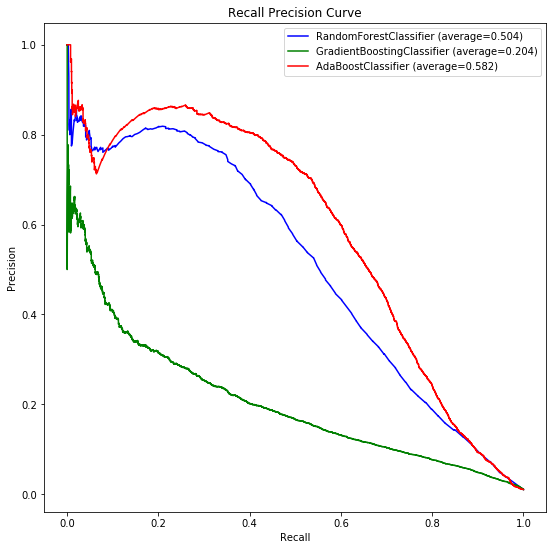

In [18]:
# plot Recall-Precision Curves
fig , ax1 = plt.subplots(figsize=(9,9) )
estimators =[rfmodel, gbmodel, abmodel]
classifiers=['RandomForestClassifier',
             'GradientBoostingClassifier',
             'AdaBoostClassifier']
colors = ['b', 'g', 'r']

for i, estimator in enumerate(estimators):
    y_pred_prob = estimator.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test,y_pred_prob)
    average_precision= average_precision_score(y_test, y_pred_prob, average="micro")
    plt.plot(recall, precision, label='%s (average=%.3f)'%(classifiers[i],average_precision), color=colors[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.title('Recall Precision Curve')

## Conclusion

Based on the performance of all the predictive model that I found **Tuned RandomForestClassifier** is the most suitable predictive model to choose here.
I think this model this is the best model because it has **precision score of 0.81.**


In [19]:
joblib.dump(tree_cv, "../model/RF_Tree_cv89.sav")

['../model/RF_Tree_cv89.sav']